<a href="https://colab.research.google.com/github/StephenSheng1101/DMAsgmnt/blob/main/Ridge%20Regression%20Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ridge Regression**


**Data Preprocessing before begin with Ridge Regression**

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler

In [2]:
transport = pd.read_csv("dataset.csv")
transport.describe()
transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142312 entries, 0 to 142311
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              142312 non-null  object 
 1   travel_fee      142312 non-null  float64
 2   departure_time  142312 non-null  object 
 3   departure_long  142311 non-null  float64
 4   departure_lat   142311 non-null  float64
 5   arrival_long    142311 non-null  float64
 6   arrival_lat     142311 non-null  float64
 7   occupancy       142311 non-null  float64
dtypes: float64(6), object(2)
memory usage: 8.7+ MB


In [3]:
transport.isnull().sum()

ID                0
travel_fee        0
departure_time    0
departure_long    1
departure_lat     1
arrival_long      1
arrival_lat       1
occupancy         1
dtype: int64

In [4]:
#handling missing value
transport["departure_long"].fillna(transport["departure_long"].mean(), inplace=True)
transport["departure_lat"].fillna(transport["departure_lat"].mean(), inplace=True)
transport["occupancy"].fillna(transport["occupancy"].mode()[0], inplace=True)
transport.drop(columns=['ID'], inplace=True)

# Drop rows with missing "departure_time","arrival_long" and "arrival_lat"
transport.dropna(subset=["departure_time", "arrival_long", "arrival_lat"],inplace = True)
transport.isnull().sum()

# Drop rows with a 0 value of occupancy
transport = transport.drop(transport[transport['occupancy'] <= 0].index)

# Handling Outliers
# Select columns for numeric attributes
num_attribs = ['departure_long', 'departure_lat', 'arrival_long', 'arrival_lat', 'occupancy', 'travel_fee']

# Remove outliers using Z-score method
z_scores = np.abs((transport[num_attribs] - transport[num_attribs].mean()) / transport[num_attribs].std())
transport = transport[(z_scores < 3).all(axis=1)]
transport.info()
transport

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130334 entries, 0 to 142310
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   travel_fee      130334 non-null  float64
 1   departure_time  130334 non-null  object 
 2   departure_long  130334 non-null  float64
 3   departure_lat   130334 non-null  float64
 4   arrival_long    130334 non-null  float64
 5   arrival_lat     130334 non-null  float64
 6   occupancy       130334 non-null  float64
dtypes: float64(6), object(1)
memory usage: 8.0+ MB


,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy
0,7.0,2013-07-02 19:54:00+00:00,-74.005360,40.728867,-74.008913,40.710907,1.0
1,5.5,2013-09-28 00:21:31+00:00,-74.014165,40.708941,-74.016310,40.716734,1.0
2,21.5,2013-06-16 03:18:00+00:00,-73.991075,40.760352,-73.941382,40.713292,1.0
3,9.5,2013-07-20 13:43:00+00:00,-74.002662,40.723630,-73.991722,40.748905,5.0
4,15.5,2013-11-05 22:57:17+00:00,-73.962397,40.712705,-73.996834,40.680403,2.0
...,...,...,...,...,...,...,...
142306,8.0,2013-10-13 00:37:55+00:00,-73.977454,40.746325,-73.991712,40.727343,1.0
142307,6.5,2013-07-13 14:03:00+00:00,-73.979192,40.764117,-73.985197,40.759157,1.0
142308,37.0,2013-09-22 17:43:16+00:00,-73.870787,40.773677,-73.965203,40.791116,2.0
142309,8.0,2013-10-05 00:18:00+00:00,-73.939665,40.723177,-73.943695,40.702180,1.0


In [5]:
transport.head()

,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy
0,7.0,2013-07-02 19:54:00+00:00,-74.005360,40.728867,-74.008913,40.710907,1.0
1,5.5,2013-09-28 00:21:31+00:00,-74.014165,40.708941,-74.016310,40.716734,1.0
2,21.5,2013-06-16 03:18:00+00:00,-73.991075,40.760352,-73.941382,40.713292,1.0
3,9.5,2013-07-20 13:43:00+00:00,-74.002662,40.723630,-73.991722,40.748905,5.0
4,15.5,2013-11-05 22:57:17+00:00,-73.962397,40.712705,-73.996834,40.680403,2.0


In [6]:
# Convert departure_time to datetime
transport['departure_time'] = pd.to_datetime(transport['departure_time'])

# Extract features from departure_time
transport['hour_of_day'] = transport['departure_time'].dt.hour
transport['day_of_week'] = transport['departure_time'].dt.dayofweek

<ipython-input-6-332d508e48d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transport['departure_time'] = pd.to_datetime(transport['departure_time'])
<ipython-input-6-332d508e48d2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transport['hour_of_day'] = transport['departure_time'].dt.hour


In [7]:
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(transport.head(500000), test_size=0.2, random_state=42)

print("Length of train_set:", len(train_set))
print("Length of test_set:", len(test_set))

Length of train_set: 104267
Length of test_set: 26067


In [8]:
travelfee = train_set.drop("travel_fee", axis=1)
travelfee_labels = train_set["travel_fee"].copy()

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

num_attribs = [ 'departure_long', 'departure_lat', 'arrival_long', 'arrival_lat', 'hour_of_day', 'day_of_week','occupancy']

num_pipeline = make_pipeline(
    StandardScaler()  # Scale features
)
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    # Apply numeric pipeline to numeric attributes
])

In [10]:
transport_prepared = preprocessing.fit_transform(transport)
transport_prepared

array([[-0.41795944, -0.56049001, -0.51393046, ...,  0.83641059,
        -1.0409902 , -0.48862382],
       [-0.55196051, -1.04623916, -0.62980102, ..., -2.05149707,
         0.99957119, -0.48862382],
       [-0.20055965,  0.20704044,  0.54391117, ..., -1.59551165,
         1.50971154, -0.48862382],
       ...,
       [ 1.63007297,  0.53187269,  0.17076631, ...,  0.53242031,
         1.50971154,  0.431603  ],
       [ 0.58183613, -0.69919887,  0.5076791 , ..., -2.05149707,
         0.99957119, -0.48862382],
       [-0.15429466, -0.48211585, -0.28701403, ...,  0.98840573,
        -0.53084985, -0.48862382]])

**Select and Train a Model on the Prepared Training Set**

**Ridge Regression**

Ridge Regression is a regularization technique used to prevent overfitting in linear regression models by adding a penalty term to the cost function based on the L2 norm of the coefficients. Let's continue with implementing Ridge Regression the preprocessed data.

In [11]:
#Imported necessary libraries and modules
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics.pairwise import euclidean_distances

In [12]:
# Define features (X) and target variable (y)
X = transport_prepared[:, 1:]  # Exclude the 'travel_fee' column
y = transport_prepared[:, 0]   # Use the 'travel_fee' column as the target variable


In [13]:
# Define different alpha values
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [14]:
# Create an empty dictionary to store RMSE scores for each alpha
rmse_scores_dict = {}

In [15]:
# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
# Iterate through each alpha value
for alpha in alphas:
    # Create a Ridge Regression model with the current alpha
    model = Ridge(alpha=alpha)

    # Perform K-fold cross-validation
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error'))

    # Store the RMSE scores in the dictionary
    rmse_scores_dict[alpha] = rmse_scores

In [17]:
# Convert the dictionary into a DataFrame for easier analysis
rmse_df = pd.DataFrame(rmse_scores_dict)

In [18]:
# Calculate the mean RMSE and standard deviation for each alpha
rmse_mean = rmse_df.mean()
rmse_std = rmse_df.std()

In [19]:
# Find the alpha with the lowest mean RMSE
best_alpha = rmse_mean.idxmin()

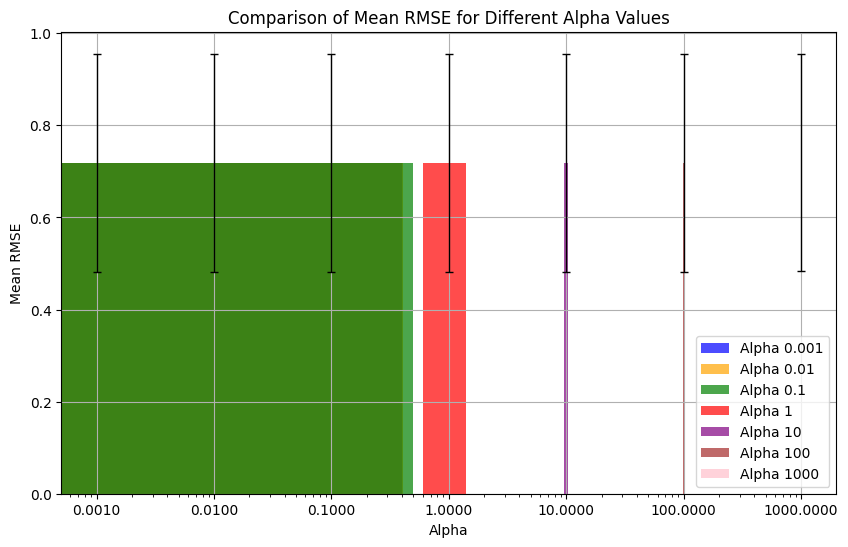

Mean RMSE for each alpha:
0.0010000000: 0.7183185650
0.0100000000: 0.7183185713
0.1000000000: 0.7183186338
1.0000000000: 0.7183192596
10.0000000000: 0.7183255201
100.0000000000: 0.7183884595
1000.0000000000: 0.7190492884

Standard Deviation of RMSE for each alpha:
0.0010000000: 0.2371204826
0.0100000000: 0.2371204755
0.1000000000: 0.2371204045
1.0000000000: 0.2371196940
10.0000000000: 0.2371125998
100.0000000000: 0.2370427266
1000.0000000000: 0.2364474725

Best alpha: 0.001


In [20]:
# Define colors for each bar
bar_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

# Visualize the comparison between each alpha outcome using a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(alphas, rmse_mean, yerr=rmse_std, align='center', capsize=5, color=bar_colors, alpha=0.7, error_kw={'elinewidth': 1, 'capsize': 3})
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('Alpha')
plt.ylabel('Mean RMSE')
plt.title('Comparison of Mean RMSE for Different Alpha Values')
plt.xticks(alphas, ['{:.4f}'.format(a) for a in alphas])  # Set x-axis ticks to the specified alpha values
plt.grid(True)
plt.legend(bars, ['Alpha ' + str(a) for a in alphas])  # Add legend
plt.show()

print("Mean RMSE for each alpha:")
for alpha, mean_rmse in zip(alphas, rmse_mean):
    print("{:.10f}: {:.10f}".format(alpha, mean_rmse))

print("\nStandard Deviation of RMSE for each alpha:")
for alpha, std_rmse in zip(alphas, rmse_std):
    print("{:.10f}: {:.10f}".format(alpha, std_rmse))

print("\nBest alpha:", best_alpha)

# Fine-tune Ridge Regression model (shortlisted promising models) using crossvalidation.


In [21]:
from sklearn.model_selection import GridSearchCV

# Define the alpha values to search through
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Create a Ridge Regression model
ridge_model = Ridge()

# Initialize GridSearchCV with Ridge model and parameter grid
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the grid search on the data
grid_search.fit(X, y)

# Get the best alpha value and associated RMSE score
best_alpha = grid_search.best_params_['alpha']
best_rmse = np.sqrt(-grid_search.best_score_)

print("Best alpha:", best_alpha)
print("Best RMSE:", best_rmse)

Best alpha: 0.001
Best RMSE: 0.7421910903101938
